# Experiments for Stochastic Reformulation paper

In [1]:
import numpy as np
from numpy import linalg as la
import matplotlib.pyplot as plt
from scipy.signal import unit_impulse

from tqdm import tqdm_notebook as tqdm

In [2]:
# Plot display settings

#plt.rcParams['font.family'] = 'serif'
#plt.rcParams['font.serif'] = 'FreeSerif'
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['lines.markersize'] = 12
plt.rcParams['xtick.labelsize'] = 24
plt.rcParams['ytick.labelsize'] = 24
plt.rcParams['legend.fontsize'] = 24
plt.rcParams['axes.titleweight'] = 'bold'
plt.rcParams['axes.titlesize'] = 36
plt.rcParams['axes.labelsize'] = 24

plt.rc('text', usetex=True)

# Sum-of-Non-Convex Objectives

Mathematical formulation:
$$ 
f(x) = \frac{1}{2} x^T \mathbf{A} x + b^T x
= \left|\mathbf{A} = \frac{1}{n} \sum\limits_{i=1}^n a_i a_i^T \right|
= \frac{1}{n} \sum\limits_{i=1}^n \left(\frac{1}{2} x^T (a_i a_i^T) x + b^T x \right)
= \frac{1}{n} \sum\limits_{i=1}^n f_i(x)
\to \min\limits_{x \in \mathbb{R}^d}
$$ 

In [3]:
def f(A, b, x):
    return x.T @ A @ x / 2 + x.T @ b

Analytical solution: 

$$
x^* = - \mathbf{A}^{-1} b
$$

In [4]:
def solution(A, b):
    return - la.inv(A) @ b

# SGD with Uniform Sampling for PCA problem

Equivalent problem representation so each $f_i$ is non-convex
$$ D_i: D_1 + \dots D_n = 0 \\
f_i(x) = \frac{1}{2} x^T (a_i^T a_i + D_i) x + b^T x
$$

$$
\nabla f_i(x) = (a_i^T a_i + D_i) x + b
$$ 

In [5]:
def grad_f_i(a, b, D, i, x):
    return (np.outer(a[i], a[i]) + D[i]) @ x + b

In [6]:
def sgd_step(a, b, D, x, random_ind, step_size):
    grad = sum([grad_f_i(a, b, D, i, x) for i in random_ind]) / len(random_ind)
    return x - step_size * grad

# def sgd_step(A, b, x, random_ind, step_size):
#     grad = A[random_ind] @ x + b#[random_ind]
#     return  x - step_size * grad

In [7]:
def sgd(a, b, D, x_0, x_star, 
        step_size=1e-2, batch_size=1, 
        epsilon=1e-4, max_epoch=100, seed=42):
    
    np.random.seed(seed)

    n = len(D)
    x = x_0
    A = sum([np.outer(a[i], a[i]) for i in range(n)]) / n
    
    epoch_num = 0
    iter_num = 0

    error = [la.norm(x - x_star)**2]
    f_values = [f(A, b, x)]
    
#     while epoch_num < max_epoch and error[-1] > epsilon: 
#         iter_num += 1
    for iter_num in tqdm(range(max_epoch * n)):
        if error[-1] < epsilon:
            break
        random_ind = np.random.choice(n, size=batch_size, replace=True)
        x = sgd_step(a, b, D, x, random_ind, step_size)
        
        if iter_num % n == 0:
            epoch_num += 1
            
            f_values.append(f(A, b, x))
            error.append(la.norm(x - x_star)**2) 
    
    print("Number of epochs:", epoch_num)
    print("Error:", la.norm(x - x_star)**2)
    print()
    
    return x, f_values, error#, gradients

In [8]:
def select_step_size(L_curly, mu, sigma_2, epsilon=1e-4):
#     return 1 / (2 * L_curly)
#     Theorem corollary for epsilon accuracy
    return min(1 / (2 * L_curly), epsilon * mu / (4 * sigma_2))

In [9]:
# Decreasing step sizes

def adaptive_step_size(L_curly, mu, k):
    cal_K = np.ceil(L_curly / mu)
    
    if k <= 4 * cal_K:
        return 1 / (2 * L_curly)
    else:
        return (2 * k + 1) / (k + 1)**2 / mu

In [10]:
def sgd_adaptive(a, b, D, x_0, x_star, L_curly, mu,
                 batch_size=1, seed=42,
                 epsilon=1e-6, max_epoch=100):
    
    np.random.seed(seed)

    n = len(D)
    x = x_0
    A = sum([np.outer(a[i], a[i]) for i in range(n)]) / n
    
    epoch_num = 0
    iter_num = 0

    error = [la.norm(x - x_star)**2]
    f_values = [f(A, b, x)]
    
    #     while epoch_num < max_epoch and error[-1] > epsilon: 
    #         iter_num += 1
    for iter_num in tqdm(range(max_epoch * n)):
        if error[-1] < epsilon:
            break
        
        step_size = adaptive_step_size(L_curly, mu, k=iter_num)
        random_ind = np.random.choice(n, size=batch_size, replace=True)
        x = sgd_step(a, b, D, x, random_ind, step_size)
        
        if iter_num % n == 0:
            epoch_num += 1
            
            f_values.append(f(A, b, x))
            error.append(la.norm(x - x_star)**2)    
    
    print("Number of epochs:", epoch_num)
    print("Error:", la.norm(x - x_star)**2)
    print()
    
    return x, f_values, error

In [149]:
def const_vs_decr_ss_comparison(n, d, scale=10, epsilon=1e-3, max_epoch=1000, seed=0):
    np.random.seed(seed)
        
    a = np.random.normal(scale=scale, size=(n, d)) #np.random.binomial(n=1, p=0.5, size=(n, d))
    # Matrix normalization for ||a||_2 = 1
    # a = np.nan_to_num(a / (la.norm(a, axis=1, ord=2)).reshape(a.shape[0], -1))

    A = sum([np.outer(a[i], a[i]) for i in range(n)]) / n

    b = np.random.normal(scale=scale, size=d) #np.random.binomial(1, 0.5, size=d)#.reshape((d, -1))
       #np.random.rand(d)

    # Analytical solution
    x_star = solution(A, b)

    # Problem constants
    mu = min(la.eigvals(A))
    print("Mu =", mu)
    
    # Decomposition
    delta = 0.01
    D = [np.zeros((d, d)) for i in range(n)]

    for j in range(d):
        indxs = np.random.choice(n, size=int(n/2), replace=False)
        for i in range(n):
            if i in indxs:
                D[i][j, j] = delta #unit_impulse(shape=(d, d), idx=indx)
            else: 
                D[i][j, j] = - delta

    M = calculate_M(a, D)
    h = calculate_h(a, b, D, x_star)
    
    sigma_2, L_curly = calculate_sigma_and_L_curly(M, h)
    print("Sigma_2 = {} \nL_curly = {} \n".format(sigma_2, L_curly))

    step_size = select_step_size(L_curly, mu, sigma_2, epsilon)
#     step_size = 1 / (2 * L_curly)
    print("Step size:", step_size)

    x_0 = np.random.normal(size=len(x_star))
    print("Expected minimum number of steps for epsilon-accuracy:", 
          max(2 * L_curly / mu, 4 * sigma_2 / (epsilon * mu**2)) * np.log(2 * la.norm(x_star - x_0)**2 / epsilon))


    # Constant step-size
    x_const, f_vals_const, x_err_const = sgd(a, b, D, x_0, x_star, step_size, batch_size=1, epsilon=epsilon, max_epoch=max_epoch)

    # Decreasing step-size
    x_adapt, f_vals_adapt, x_err_adapt = sgd_adaptive(a, b, D, x_0, x_star, L_curly, mu, batch_size=1, epsilon=epsilon, max_epoch=max_epoch)

    
    """PLOTTING"""
    k_switch = int(4 * np.ceil(L_curly / mu) / n)
    print("Regime switch:", k_switch)
    
    fig = plt.figure(figsize=(18, 8))
    st = fig.suptitle(r"$n = {}, d = {}$".format(n, d), fontsize=36)

    plt.subplot(1, 2, 1)

    plt.semilogy(x_err_const / la.norm(x_star - x_0)**2, label='Constant step size')
    plt.semilogy(x_err_adapt / la.norm(x_star - x_0)**2, label='Decreasing step size')
    # plt.axvline(k_switch, color='red', label="Regime switch")
    plt.xlabel("Epoch number: $k$")
    plt.ylabel(r"$\|x_k - x^*\|^2$")
    plt.legend(loc='best', shadow=True)#, fontsize='x-large')

    plt.subplot(1, 2, 2)

    plt.semilogy(f_vals_const - f(A, b, x_star) / f(A, b, x_0) - f(A, b, x_star), label='Constant step size')
    plt.semilogy(f_vals_adapt - f(A, b, x_star) / f(A, b, x_0) - f(A, b, x_star), label='Decreasing step size')
    # plt.axvline(k_switch, color='red', label="Regime switch")
    plt.xlabel("Epoch number: $k$")
    plt.ylabel(r"$f(x_k) - f(x^*)$")
    plt.legend(loc='best', shadow=True)#, fontsize='x-large')

    st.set_y(1.05)
    fig.subplots_adjust(top=0.95)
    plt.tight_layout()
    plt.savefig('Sum-of-Non-Convex_Objectives_{}-{}.pdf'.format(n, d), bbox_inches='tight')
    plt.show()
    
    return [x_const, x_adapt], [f_vals_const, f_vals_adapt], [x_err_const, x_err_adapt]

Mu = 386.9594559255695
Sigma_2 = 28817.79721857571 
L_curly = 15403.247974255368 

Step size: 3.356948598383317e-06
Expected minimum number of steps for epsilon-accuracy: 7659.3077855324555



Number of epochs: 2
Error: 5.612311881084265e-05




Number of epochs: 2
Error: 3.788802921384131e-06

Regime switch: 0


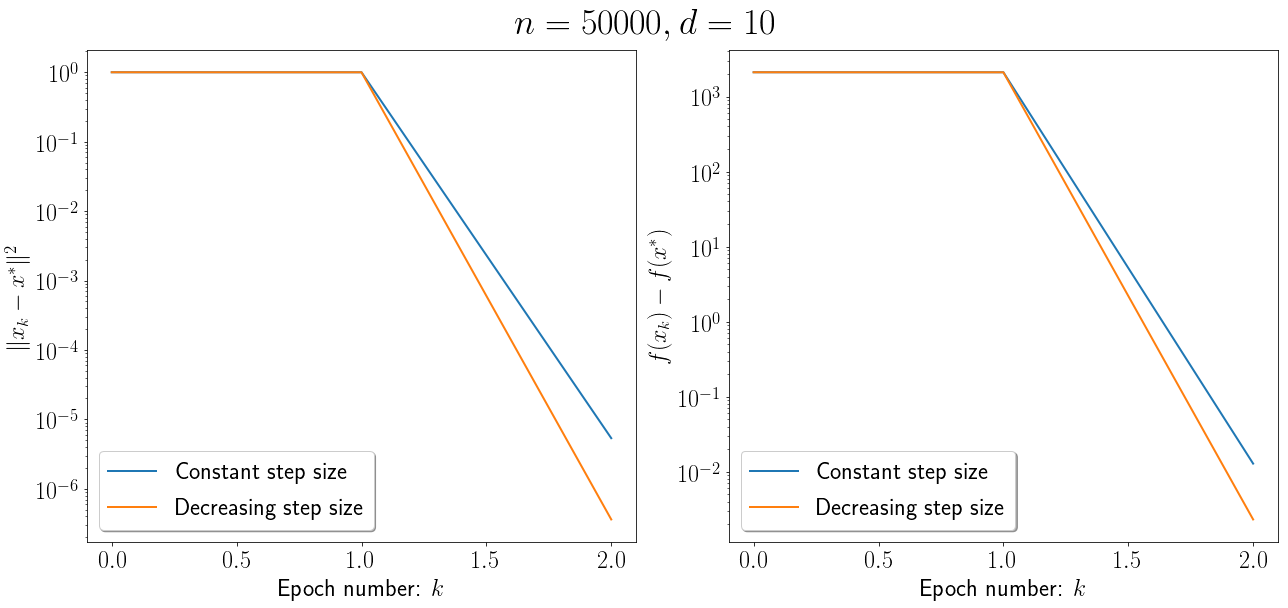

In [151]:
n, d = 50000, 10
[x_const, x_adapt], [f_vals_const, f_vals_adapt], [x_err_const, x_err_adapt] = const_vs_decr_ss_comparison(n, d, scale=20, epsilon=1e-3, max_epoch=1000, seed=0)

# Synthetic data generation according to Allen-Zhu (2016) paper

Random vectors $a_1, \dots, a_n \in [0, 1]^d$

In [76]:
# n = 500
# d = 20

# np.random.seed(1)

# a = np.random.binomial(n=1, p=0.5, size=(n, d)) * 10
# # Matrix normalization for ||a||_2 = 1
# # a = np.nan_to_num(a / (la.norm(a, axis=1, ord=2)).reshape(a.shape[0], -1))

# A = sum([np.outer(a[i], a[i]) for i in range(n)]) / n

# # np.random.rand(d) 
# b = np.random.binomial(1, 0.5, size=d)#.reshape((d, -1))

In [ ]:
n = 500
d = 20

np.random.seed(1)

# MY CHANGE
a = np.random.normal(scale = size=(n, d)) #np.random.binomial(n=1, p=0.5, size=(n, d))
# Matrix normalization for ||a||_2 = 1
# a = np.nan_to_num(a / (la.norm(a, axis=1, ord=2)).reshape(a.shape[0], -1))

A = sum([np.outer(a[i], a[i]) for i in range(n)]) / n

b = np.random.normal(size=d) #np.random.binomial(1, 0.5, size=d)#.reshape((d, -1))
# np.random.rand(d)

# Analytical solution
x_star = solution(A, b)

In [78]:
# Decomposition

D = [np.diag(np.random.rand(d) - unit_impulse(d, np.random.randint(d))) for i in range(n - 1)]
D += [- sum(D)]

### Constants calculation

<!---
L_i = \| \mathbf{A}(i,:) \|_2^2 + \lambda \ \ \forall i \\-->
$$
\mu = \lambda_{\text{min}}(\mathbf{A})
$$

In [79]:
mu = min(la.eigvals(A))
mu

16.867830990168628

In [11]:
def calculate_neighborhood_region(step_size, sigma_2, mu):
    return 2 * step_size * sigma_2 / mu

In our case M-smoothness:
$$
M_i = a_i a_i^T + D_i
$$

In [12]:
def calculate_M(a, D):
    n = len(D)
    return [np.outer(a[i], a[i]) + D[i] for i in range(n)]

$$
h_i = \| \nabla f_i(x^*) \|^2
$$

In [13]:
def calculate_h(a, b, D, x_star):
    n = len(D)
    return [la.norm(grad_f_i(a, b, D, i, x_star))**2 for i in range(n)]

For proper & non-vacuous uniform sampling:
$$
\sigma^2 = \frac{1}{n} \sum\limits_{i=1}^n \| \nabla f_i (x^*) \|^2 \\
\mathcal{L} = \max\limits_{i=\overline{1,n}} \lambda_{\text{max}}(M_i) \\
$$

In [14]:
def calculate_sigma_and_L_curly(M, h):
    n = len(M)
    sigma_2 = np.mean(h) #sum([la.norm(grad_f_i(a, b, D, i, x_star))**2 for i in range(n)]) / n
    L_curly = max([max(abs(la.eigvals(M[i]))) for i in range(n)])

    return sigma_2, L_curly

In [19]:
def const_vs_decr_ss_comparison(n, d, scale=10, epsilon=1e-3, max_epoch=1000, seed=0):
    np.random.seed(seed)
        
    a = np.random.normal(scale=scale, size=(n, d)) #np.random.binomial(n=1, p=0.5, size=(n, d))
    # Matrix normalization for ||a||_2 = 1
    # a = np.nan_to_num(a / (la.norm(a, axis=1, ord=2)).reshape(a.shape[0], -1))

    A = sum([np.outer(a[i], a[i]) for i in range(n)]) / n

    b = np.random.normal(scale=scale, size=d) #np.random.binomial(1, 0.5, size=d)#.reshape((d, -1))
       #np.random.rand(d)

    # Analytical solution
    x_star = solution(A, b)

    # Problem constants
    mu = min(la.eigvals(A))
    print("Mu =", mu)
    
    # Decomposition
    delta = 0.01
    D = [np.zeros((d, d)) for i in range(n)]

    for j in range(d):
        indxs = np.random.choice(n, size=int(n/2), replace=False)
        for i in range(n):
            if i in indxs:
                D[i][j, j] = delta #unit_impulse(shape=(d, d), idx=indx)
            else: 
                D[i][j, j] = - delta

    M = calculate_M(a, D)
    h = calculate_h(a, b, D, x_star)
    
    sigma_2, L_curly = calculate_sigma_and_L_curly(M, h)
    print("Sigma_2 = {} \nL_curly = {} \n".format(sigma_2, L_curly))

#     step_size = select_step_size(L_curly, mu, sigma_2, epsilon)
    step_size = 1 / (2 * L_curly)
    print("Step size:", step_size)

    x_0 = np.random.normal(size=len(x_star))
    print("Expected minimum number of steps for epsilon-accuracy:", 
          max(2 * L_curly / mu, 4 * sigma_2 / (epsilon * mu**2)) * np.log(2 * la.norm(x_star - x_0)**2 / epsilon))


    # Constant step-size
    x_const, f_vals_const, x_err_const = sgd(a, b, D, x_0, x_star, step_size, batch_size=1, epsilon=epsilon, max_epoch=max_epoch)

    # Decreasing step-size
    x_adapt, f_vals_adapt, x_err_adapt = sgd_adaptive(a, b, D, x_0, x_star, L_curly, mu, batch_size=1, epsilon=epsilon, max_epoch=max_epoch)

    
    """PLOTTING"""
    k_switch = int(4 * np.ceil(L_curly / mu) / n)
    print("Regime switch:", k_switch)
    
    fig = plt.figure(figsize=(18, 8))
    st = fig.suptitle(r"$n = {}, d = {}$".format(n, d), fontsize=36)

    plt.subplot(1, 2, 1)

    plt.semilogy(x_err_const / la.norm(x_star - x_0)**2, label='Constant step size')
    plt.semilogy(x_err_adapt / la.norm(x_star - x_0)**2, label='Decreasing step size')
    # plt.axvline(k_switch, color='red', label="Regime switch")
    plt.xlabel("Epoch number: $k$")
    plt.ylabel(r"$\|x_k - x^*\|^2$")
    plt.legend(loc='best', shadow=True)#, fontsize='x-large')

    plt.subplot(1, 2, 2)

    plt.semilogy(f_vals_const - f(A, b, x_star) / f(A, b, x_0) - f(A, b, x_star), label='Constant step size')
    plt.semilogy(f_vals_adapt - f(A, b, x_star) / f(A, b, x_0) - f(A, b, x_star), label='Decreasing step size')
    # plt.axvline(k_switch, color='red', label="Regime switch")
    plt.xlabel("Epoch number: $k$")
    plt.ylabel(r"$f(x_k) - f(x^*)$")
    plt.legend(loc='best', shadow=True)#, fontsize='x-large')

    st.set_y(1.05)
    fig.subplots_adjust(top=0.95)
    plt.tight_layout()
    plt.savefig('Sum-of-Non-Convex_Objectives_{}-{}.pdf'.format(n, d), bbox_inches='tight')
    plt.show()
    
    return [x_const, x_adapt], [f_vals_const, f_vals_adapt], [x_err_const, x_err_adapt]

In [ ]:
%%time
n, d = 1000, 100
[x_const, x_adapt], \
[f_vals_const, f_vals_adapt], \
[x_err_const, x_err_adapt] = const_vs_decr_ss_comparison(n, d, scale=20, epsilon=1e-3, max_epoch=100, seed=0)

In [83]:
M = calculate_M(a, D)
h = calculate_h(a, b, D, x_star)
sigma_2, L_curly = calculate_sigma_and_L_curly(M, h)
print("sigma_2 = {} \nL_curly = {}".format(sigma_2, L_curly))

sigma_2 = 203.85579471275832 
L_curly = 1700.4637195909274


In [91]:
epsilon = 1e-5

# Far from solution
x_0 = np.random.normal(size=len(x_star))

# Closer to solution
# x_0 = x_star + np.random.normal(size=len(x_star))

In [92]:
step_size = select_step_size(L_curly, mu, sigma_2, epsilon)
print("Step size:", step_size)

print("Expected minimum number of steps:", 
      max(2 * L_curly / mu, 4 * sigma_2 / (epsilon * mu**2)) * np.log(2 * la.norm(x_star - x_0)**2 / epsilon))

Step size: 2.0685984195269183e-07
Expected minimum number of steps: 4318089.144151602


In [93]:
max_epoch = 10000

In [94]:
%%time
x_opt, f_vals, x_err = sgd(A, b, D, x_0, x_star, step_size, batch_size=1,
                           epsilon=epsilon, max_epoch=max_epoch)

Number of epochs: 3465
Error: 9.883662258805172e-06

CPU times: user 1min 28s, sys: 800 ms, total: 1min 29s
Wall time: 1min 32s


In [95]:
# %%time
# x_opt_adapt, f_vals_adapt, x_err_adapt = sgd_adaptive(A, b, D, x_0, x_star, L_curly, mu, batch_size=1, 
#                                                       epsilon=epsilon, max_epoch=max_epoch)

In [96]:
# # Switching regime from constant to decreasing step size
# k_switch = int(4 * np.ceil(L_curly / mu)) / n
# k_switch

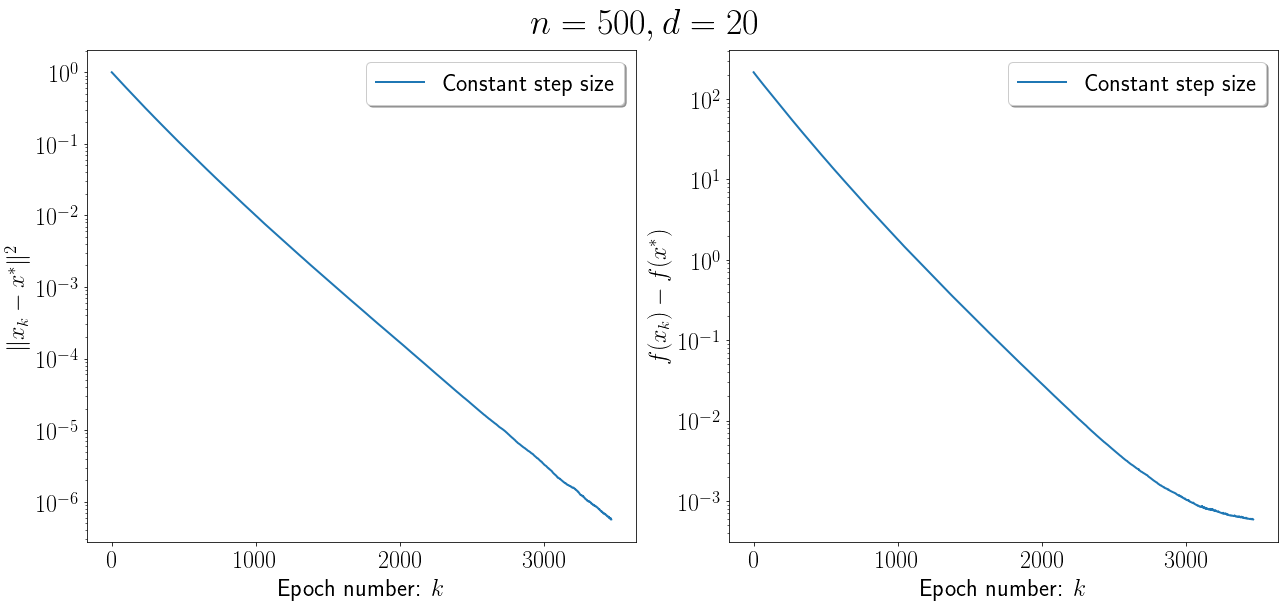

In [97]:
fig = plt.figure(figsize=(18, 8))
st = fig.suptitle(r"$n = {}, d = {}$".format(n, d), fontsize=36)

plt.subplot(1, 2, 1)

plt.semilogy(x_err / la.norm(x_star - x_0)**2, label='Constant step size')
# plt.semilogy(x_err_adapt, label='Decreasing step size')
# plt.axvline(k_switch, color='red', label="Regime switch")
plt.xlabel("Epoch number: $k$")
plt.ylabel(r"$\|x_k - x^*\|^2$")
plt.legend(loc='best', shadow=True)#, fontsize='x-large')

plt.subplot(1, 2, 2)

plt.semilogy(f_vals - f(A, b, x_star) / f(A, b, x_0) - f(A, b, x_star), label='Constant step size')
# plt.semilogy(f_vals_adapt - f(A, b, x_star), label='Decreasing step size')
# plt.axvline(k_switch, color='red', label="Regime switch")
plt.xlabel("Epoch number: $k$")
plt.ylabel(r"$f(x_k) - f(x^*)$")
plt.legend(loc='best', shadow=True)#, fontsize='x-large')

st.set_y(1.05)
fig.subplots_adjust(top=0.95)
plt.tight_layout()
plt.savefig('Sum-of-Non-Convex_Objectives_{}-{}.pdf'.format(n, d), bbox_inches='tight')
plt.show()

### Another way to generate $D_i$ from Allen-Zhu paper

In [51]:
delta = 0.01

In [52]:
# Decomposition

D = [np.zeros((d, d)) for i in range(n)]

for j in range(d):
    indxs = np.random.choice(n, size=int(n/2), replace=False)
    for i in range(n):
        if i in indxs:
            D[i][j, j] = delta #unit_impulse(shape=(d, d), idx=indx)
        else: 
            D[i][j, j] = - delta

In [53]:
# mu = min(la.eigvals(A))
print("mu =", mu)

M = calculate_M(a, D)
h = calculate_h(a, b, D, x_star)
sigma_2, L_curly = calculate_sigma_and_L_curly(M, h)

print("sigma_2 = {} \nL_curly = {}".format(sigma_2, L_curly))

mu = 18.003005549992796
sigma_2 = 12.188607451360589 
L_curly = 500.00600012799725


In [54]:
# Far from solution
x_0 = np.random.normal(size=len(x_star))

# Closer to solution
# x_0 = x_star + np.random.normal(size=len(x_star))

epsilon = 1e-5

step_size = select_step_size(L_curly, mu, sigma_2, epsilon)
print("Step size:", step_size)

print("Expected minimum number of steps:", 
      max(2 * L_curly / mu, 4 * sigma_2 / (epsilon * mu**2)) * np.log(2 * la.norm(x_star - x_0)**2 / epsilon))

Step size: 3.6925886779590966e-06
Expected minimum number of steps: 193277.62654699475


In [55]:
max_epoch = 10000

In [56]:
%%time
x_opt, f_vals, x_err = sgd(A, b, D, x_0, x_star, step_size, batch_size=1, 
                           epsilon=epsilon, max_epoch=max_epoch)

Number of epochs: 1700
Error: 9.985977101830576e-06

CPU times: user 3.91 s, sys: 22.2 ms, total: 3.94 s
Wall time: 3.99 s


In [60]:
%%time
x_opt_adapt, f_vals_adapt, x_err_adapt = sgd_adaptive(A, b, D, x_0, x_star, L_curly, mu, batch_size=1, 
                                                      epsilon=epsilon, max_epoch=max_epoch)

Number of epochs: 31
Error: 7.687554106085256e-06

CPU times: user 124 ms, sys: 10.7 ms, total: 135 ms
Wall time: 137 ms


In [61]:
# Switching regime from constant to decreasing step size
k_switch = int(4 * np.ceil(L_curly / mu)) / n
k_switch

2.24

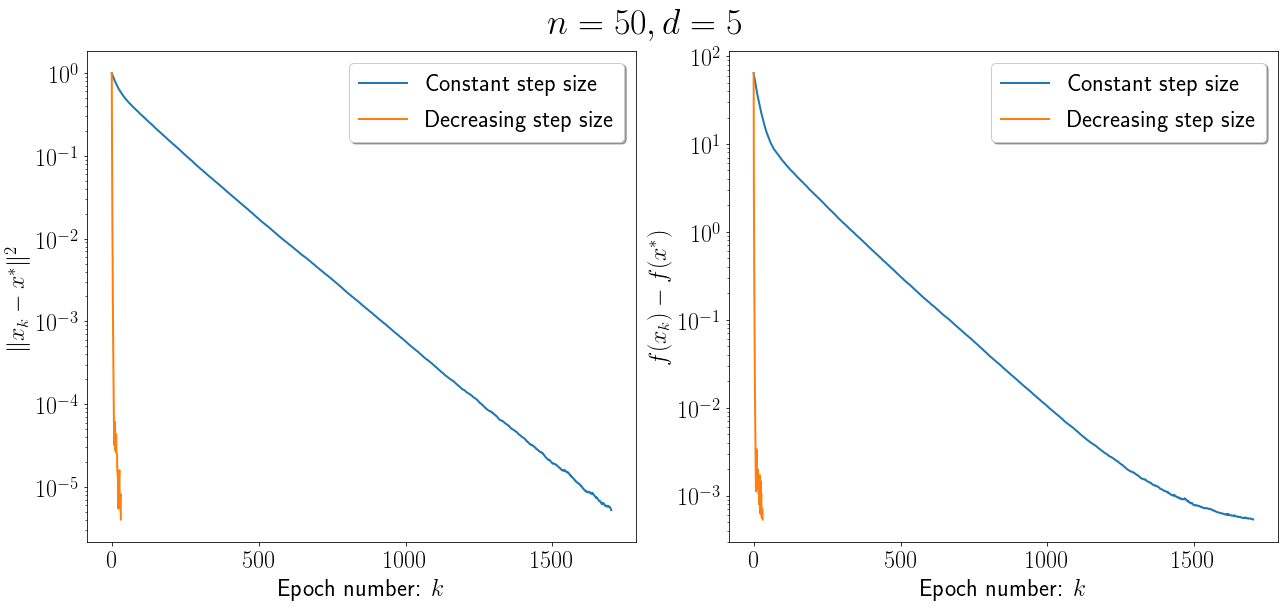

In [63]:
fig = plt.figure(figsize=(18, 8))
st = fig.suptitle(r"$n = {}, d = {}$".format(n, d), fontsize=36)

plt.subplot(1, 2, 1)

plt.semilogy(x_err / la.norm(x_star - x_0)**2, label='Constant step size')
# plt.semilogy(x_err_adapt / la.norm(x_star - x_0)**2, label='Decreasing step size')
# plt.axvline(k_switch, color='red', label="Regime switch")
plt.xlabel("Epoch number: $k$")
plt.ylabel(r"$\|x_k - x^*\|^2$")
plt.legend(loc='best', shadow=True)#, fontsize='x-large')

plt.subplot(1, 2, 2)

plt.semilogy(f_vals - f(A, b, x_star) / f(A, b, x_0) - f(A, b, x_star), label='Constant step size')
# plt.semilogy(f_vals_adapt - f(A, b, x_star) / f(A, b, x_0) - f(A, b, x_star), label='Decreasing step size')
# plt.axvline(k_switch, color='red', label="Regime switch")
plt.xlabel("Epoch number: $k$")
plt.ylabel(r"$f(x_k) - f(x^*)$")
plt.legend(loc='best', shadow=True)#, fontsize='x-large')

st.set_y(1.05)
fig.subplots_adjust(top=0.95)
plt.tight_layout()
plt.savefig('Sum-of-Non-Convex_Objectives_{}-{}.pdf'.format(n, d), bbox_inches='tight')
plt.show()

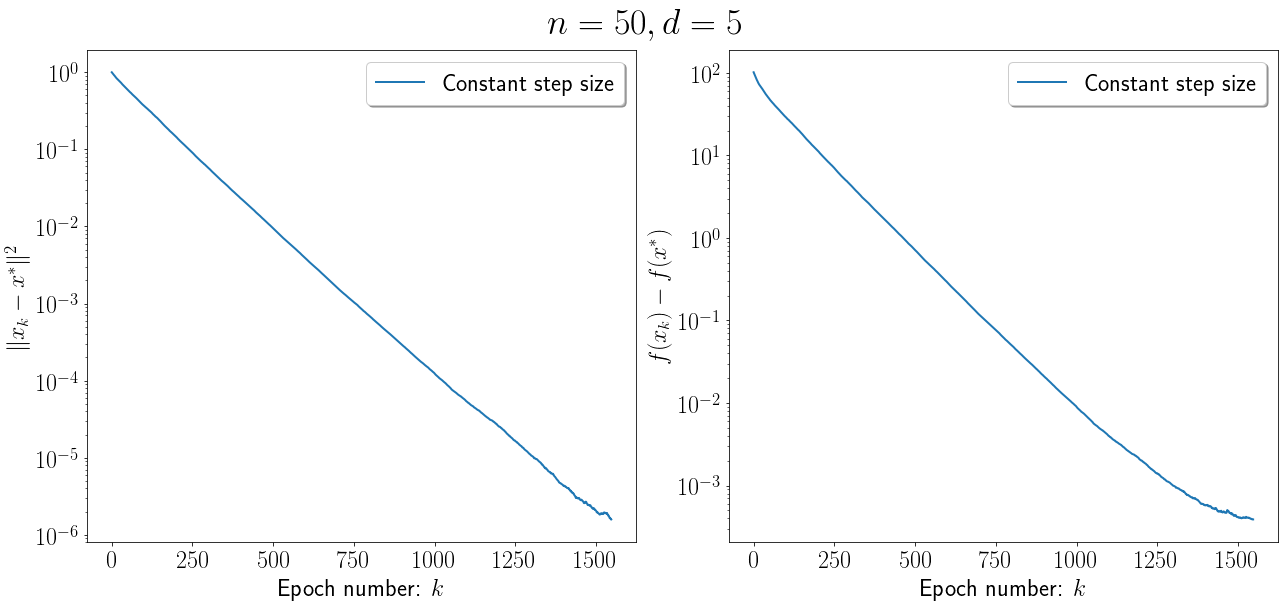

In [50]:
fig = plt.figure(figsize=(18, 8))
st = fig.suptitle(r"$n = {}, d = {}$".format(n, d), fontsize=36)

plt.subplot(1, 2, 1)

plt.semilogy(x_err / la.norm(x_star - x_0)**2, label='Constant step size')
# plt.semilogy(x_err_adapt, label='Decreasing step size')
# plt.axvline(k_switch, color='red', label="Regime switch")
plt.xlabel("Epoch number: $k$")
plt.ylabel(r"$\|x_k - x^*\|^2$")
plt.legend(loc='best', shadow=True)#, fontsize='x-large')

plt.subplot(1, 2, 2)

plt.semilogy(f_vals - f(A, b, x_star) / f(A, b, x_0) - f(A, b, x_star), label='Constant step size')
# plt.semilogy(f_vals_adapt - f(A, b, x_star), label='Decreasing step size')
# plt.axvline(k_switch, color='red', label="Regime switch")
plt.xlabel("Epoch number: $k$")
plt.ylabel(r"$f(x_k) - f(x^*)$")
plt.legend(loc='best', shadow=True)#, fontsize='x-large')

st.set_y(1.05)
fig.subplots_adjust(top=0.95)
plt.tight_layout()
plt.savefig('Sum-of-Non-Convex_Objectives_{}-{}.pdf'.format(n, d), bbox_inches='tight')
plt.show()

### Third way to generate $D_i$ from Allen-Zhu (2016) paper

In [78]:
k = 5

In [79]:
# Decomposition

D = [np.eye(d) * k / (n - 1) for i in range(n)]

for j in range(d):
    ind = np.random.choice(n)
    D[ind][j, j] = - k

In [80]:
mu = min(la.eigvals(A))
print("mu =", mu)

M = calculate_M(a, D)
h = calculate_h(a, b, D, x_star)
sigma_2, L_curly = calculate_sigma_and_L_curly(M, h)

print("sigma_2 = {} \nL_curly = {}".format(sigma_2, L_curly))

mu = 0.005510413402311755
sigma_2 = 38968.43287821895 
L_curly = 5.0


In [81]:
# Far from solution
x_0 = np.random.normal(size=len(x_star))

# Closer to solution
# x_0 = x_star + np.random.normal(size=len(x_star))

epsilon = 1e-3

step_size = select_step_size(L_curly, mu, sigma_2, epsilon)
print("Step size:", step_size)

print("Expected minimum number of steps:", 
      max(2 * L_curly / mu, 4 * sigma_2 / (epsilon * mu**2)) * np.log(2 * la.norm(x_star - x_0)**2 / epsilon))

Step size: 0.1
Expected minimum number of steps: 96575126878236.56


In [82]:
max_epoch = 10000

In [83]:
%%time
x_opt, f_vals, x_err = sgd(A, b, D, x_0, x_star, step_size, batch_size=1, 
                           epsilon=epsilon, max_epoch=max_epoch)

Number of epochs: 10000
Error: 83422.29485135339

CPU times: user 28.5 s, sys: 187 ms, total: 28.7 s
Wall time: 30 s


In [84]:
%%time
x_opt_adapt, f_vals_adapt, x_err_adapt = sgd_adaptive(A, b, D, x_0, x_star, L_curly, mu, batch_size=1, 
                                                      epsilon=epsilon, max_epoch=max_epoch)

Number of epochs: 10000
Error: 905.2526547570698

CPU times: user 28.6 s, sys: 216 ms, total: 28.8 s
Wall time: 29.5 s


In [85]:
# Switching regime from constant to decreasing step size
k_switch = int(4 * np.ceil(L_curly / mu)) / n
k_switch

72.64

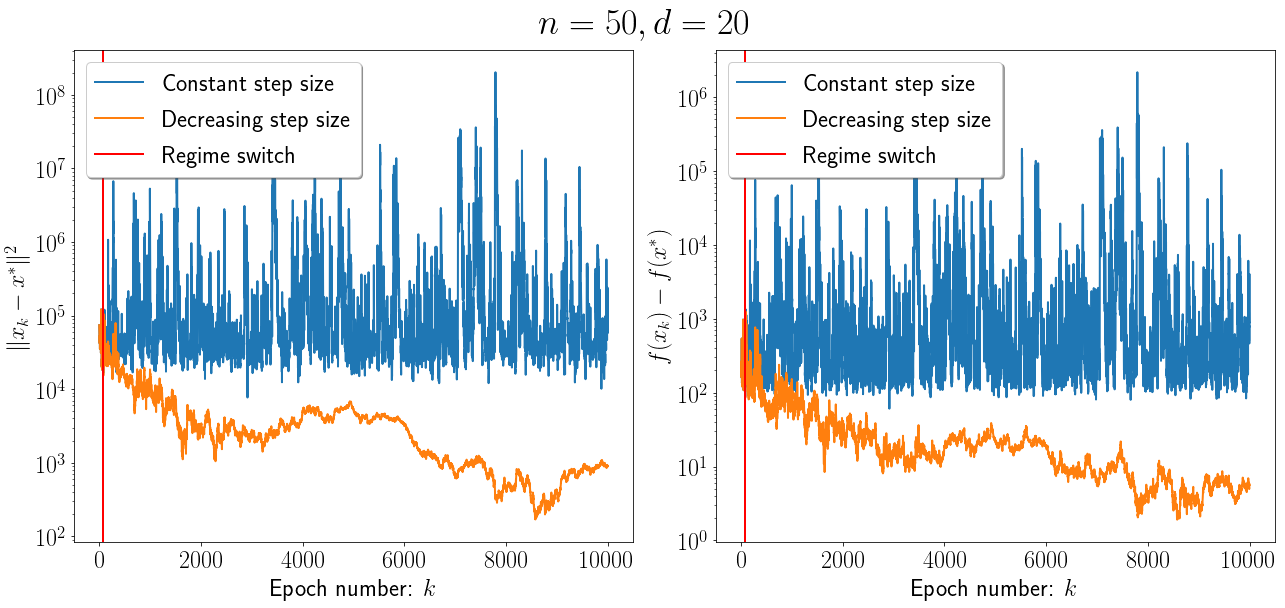

In [86]:
fig = plt.figure(figsize=(18, 8))
st = fig.suptitle(r"$n = {}, d = {}$".format(n, d), fontsize=36)

plt.subplot(1, 2, 1)

plt.semilogy(x_err, label='Constant step size')
plt.semilogy(x_err_adapt, label='Decreasing step size')
plt.axvline(k_switch, color='red', label="Regime switch")
plt.xlabel("Epoch number: $k$")
plt.ylabel(r"$\|x_k - x^*\|^2$")
plt.legend(loc='best', shadow=True)#, fontsize='x-large')

plt.subplot(1, 2, 2)

plt.semilogy(f_vals - f(A, b, x_star), label='Constant step size')
plt.semilogy(f_vals_adapt - f(A, b, x_star), label='Decreasing step size')
plt.axvline(k_switch, color='red', label="Regime switch")
plt.xlabel("Epoch number: $k$")
plt.ylabel(r"$f(x_k) - f(x^*)$")
plt.legend(loc='best', shadow=True)#, fontsize='x-large')

st.set_y(1.05)
fig.subplots_adjust(top=0.95)
plt.tight_layout()
# plt.savefig('synthetic_{}-{}.pdf'.format(n, d), bbox_inches='tight')
plt.savefig('3_Sum-of-Non-Convex_Objectives_{}-{}.pdf'.format(n, d), bbox_inches='tight')
plt.show()

## Another type of data generation

Random vectors $a_1, \dots, a_n$ from standart multivariate normal

In [126]:
n = 10
d = 4

np.random.seed(0)

a = np.random.normal(size=(n, d))
# Matrix normalization for ||a||_2 = 1
# a = np.nan_to_num(a / (la.norm(a, axis=1, ord=2)).reshape(a.shape[0], -1))

A = sum([np.outer(a[i], a[i]) for i in range(n)]) / n

b = np.random.normal(size=d)#.reshape((d, -1))

In [127]:
# Analytical solution
x_star = solution(A, b)

In [128]:
# k = 5

In [129]:
# # Decomposition

# D = [np.eye(d) * k / (n - 1) for i in range(n)]

# for j in range(d):
#     ind = np.random.choice(n)
#     D[ind][j, j] = - k

In [130]:
# Decomposition

D = [np.diag(np.random.rand(d) - unit_impulse(d, np.random.randint(d))) for i in range(n - 1)]
D += [- sum(D)]

In [131]:
M = [np.outer(a[i], a[i]) + D[i] for i in range(n)]

mu = min(la.eigvals(A))
print("mu =", mu)

sigma_2 = sum([la.norm(grad_f_i(a, b, D, i, x_star))**2 for i in range(n)]) / n
L_curly = abs(max([max(la.eigvals(M[i])) for i in range(len(M))])) # maybe cast abs() for complex results
print("sigma_2, L_curly =", sigma_2, L_curly)

mu = 0.27231374052156554
sigma_2, L_curly = 186.69621851902124 9.359373138730774


In [132]:
# Far from solution
x_0 = np.random.normal(size=len(x_star))

# Closer to solution
# x_0 = x_star + np.random.normal(size=len(x_star))

epsilon = 1e-4

step_size = select_step_size(L_curly, mu, sigma_2, epsilon)
print("Step size:", step_size)

print("Expected minimum number of steps:", 
      max(2 * L_curly / mu, 4 * sigma_2 / (epsilon * mu**2)) * np.log(2 * la.norm(x_star - x_0)**2 / epsilon))

Step size: 0.0534223812416357
Expected minimum number of steps: 1411738332.0786586


In [155]:
max_epoch = 500000

In [156]:
%%time
x_opt, f_vals, x_err = sgd(A, b, D, x_0, x_star, step_size, batch_size=1, 
                           epsilon=epsilon, max_epoch=max_epoch)

Number of epochs: 500000
Error: 5.246696578905769

CPU times: user 3min 39s, sys: 1.51 s, total: 3min 40s
Wall time: 3min 46s


In [157]:
%%time
x_opt_adapt, f_vals_adapt, x_err_adapt = sgd_adaptive(A, b, D, x_0, x_star, L_curly, mu, batch_size=1, 
                                                      epsilon=epsilon, max_epoch=max_epoch)

Number of epochs: 230580
Error: 9.766090386247642e-05

CPU times: user 1min 54s, sys: 808 ms, total: 1min 55s
Wall time: 1min 58s


In [158]:
# Switching regime from constant to decreasing step size
k_switch = int(4 * np.ceil(L_curly / mu)) / n
k_switch

14.0

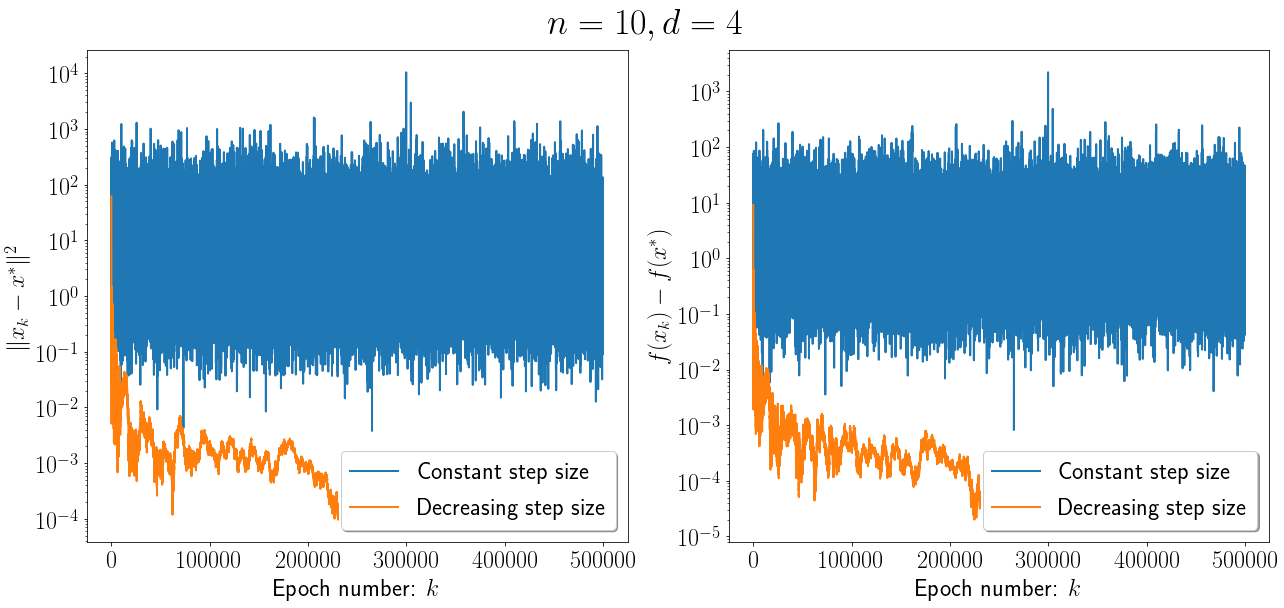

In [159]:
fig = plt.figure(figsize=(18, 8))
st = fig.suptitle(r"$n = {}, d = {}$".format(n, d), fontsize=36)

plt.subplot(1, 2, 1)

plt.semilogy(x_err, label='Constant step size')
plt.semilogy(x_err_adapt, label='Decreasing step size')
plt.xlabel("Epoch number: $k$")
plt.ylabel(r"$\|x_k - x^*\|^2$")
plt.legend(loc='best', shadow=True)#, fontsize='x-large')

plt.subplot(1, 2, 2)

plt.semilogy(f_vals - f(A, b, x_star), label='Constant step size')
plt.semilogy(f_vals_adapt - f(A, b, x_star), label='Decreasing step size')
plt.xlabel("Epoch number: $k$")
plt.ylabel(r"$f(x_k) - f(x^*)$")
plt.legend(loc='best', shadow=True)#, fontsize='x-large')

st.set_y(1.05)
fig.subplots_adjust(top=0.95)
plt.tight_layout()
# plt.savefig('synthetic_{}-{}.pdf'.format(n, d), bbox_inches='tight')
plt.show()

# Real data

In [177]:
!wget -t inf https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/binary/leu.bz2

--2019-01-22 10:21:37--  https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/binary/leu.bz2
Resolving www.csie.ntu.edu.tw (www.csie.ntu.edu.tw)... 140.112.30.26
Connecting to www.csie.ntu.edu.tw (www.csie.ntu.edu.tw)|140.112.30.26|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1423727 (1.4M) [application/x-bzip2]
Saving to: ‘leu.bz2’

leu.bz2             100%[===================>]   1.36M   649KB/s    in 2.1s    

2019-01-22 10:21:40 (649 KB/s) - ‘leu.bz2’ saved [1423727/1423727]



In [178]:
!bzip2 -dk leu.bz2

In [15]:
from sklearn.datasets import load_svmlight_file

def get_data():
    data = load_svmlight_file("/home/sailana/Desktop/new/leu")
    return data[0], data[1]

In [16]:
a, y = get_data()
a = np.array(a.todense())

In [17]:
a.shape

(38, 7129)

In [18]:
np.random.seed(0)

n = a.shape[0]
d = a.shape[1]

A = sum([np.outer(a[i], a[i]) for i in range(n)]) / n

b = np.random.normal(size=d) #np.random.binomial(1, 0.5, size=d)#.reshape((d, -1))
   #np.random.rand(d)
    
# Problem constants
mu = min(la.eigvals(A))
print("Mu =", mu)

# Analytical solution
x_star = solution(A, b)

# Decomposition
delta = 0.01
D = [np.zeros((d, d)) for i in range(n)]

for j in range(d):
    indxs = np.random.choice(n, size=int(n/2), replace=False)
    for i in range(n):
        if i in indxs:
            D[i][j, j] = delta #unit_impulse(shape=(d, d), idx=indx)
        else: 
            D[i][j, j] = - delta

M = calculate_M(a, D)
h = calculate_h(a, b, D, x_star)

sigma_2, L_curly = calculate_sigma_and_L_curly(M, h)
print("Sigma_2 = {} \nL_curly = {} \n".format(sigma_2, L_curly))

step_size = select_step_size(L_curly, mu, sigma_2, epsilon)
#     step_size = 1 / (2 * L_curly)
print("Step size:", step_size)

x_0 = np.random.normal(size=len(x_star))
print("Expected minimum number of steps for epsilon-accuracy:", 
      max(2 * L_curly / mu, 4 * sigma_2 / (epsilon * mu**2)) * np.log(2 * la.norm(x_star - x_0)**2 / epsilon))

Mu = (-2.6482434001546166e-14+0j)


KeyboardInterrupt: 

In [ ]:
# Constant step-size
x_const, f_vals_const, x_err_const = sgd(a, b, D, x_0, x_star, step_size, batch_size=1, epsilon=epsilon, max_epoch=max_epoch)

# Decreasing step-size
x_adapt, f_vals_adapt, x_err_adapt = sgd_adaptive(a, b, D, x_0, x_star, L_curly, mu, batch_size=1, epsilon=epsilon, max_epoch=max_epoch)


"""PLOTTING"""
k_switch = int(4 * np.ceil(L_curly / mu) / n)
print("Regime switch:", k_switch)

fig = plt.figure(figsize=(18, 8))
st = fig.suptitle(r"$n = {}, d = {}$".format(n, d), fontsize=36)

plt.subplot(1, 2, 1)

plt.semilogy(x_err_const / la.norm(x_star - x_0)**2, label='Constant step size')
plt.semilogy(x_err_adapt / la.norm(x_star - x_0)**2, label='Decreasing step size')
# plt.axvline(k_switch, color='red', label="Regime switch")
plt.xlabel("Epoch number: $k$")
plt.ylabel(r"$\|x_k - x^*\|^2$")
plt.legend(loc='best', shadow=True)#, fontsize='x-large')

plt.subplot(1, 2, 2)

plt.semilogy(f_vals_const - f(A, b, x_star) / f(A, b, x_0) - f(A, b, x_star), label='Constant step size')
plt.semilogy(f_vals_adapt - f(A, b, x_star) / f(A, b, x_0) - f(A, b, x_star), label='Decreasing step size')
# plt.axvline(k_switch, color='red', label="Regime switch")
plt.xlabel("Epoch number: $k$")
plt.ylabel(r"$f(x_k) - f(x^*)$")
plt.legend(loc='best', shadow=True)#, fontsize='x-large')

st.set_y(1.05)
fig.subplots_adjust(top=0.95)
plt.tight_layout()
plt.savefig('Sum-of-Non-Convex_Objectives_{}-{}.pdf'.format(n, d), bbox_inches='tight')
plt.show()

### 1 type of $D_i$ generation

In [186]:
delta = 0.01

In [187]:
# Decomposition

D = [np.zeros((d, d)) for i in range(n)]

for j in range(d):
    indxs = np.random.choice(n, size=int(n/2), replace=False)
    for i in range(n):
        if i in indxs:
            D[i][j, j] = delta #unit_impulse(shape=(d, d), idx=indx)
        else: 
            D[i][j, j] = - delta

In [188]:
mu = min(la.eigvals(A))
print("mu =", mu)

M = calculate_M(a, D)
h = calculate_h(a, b, D, x_star)

sigma_2, L_curly = calculate_sigma_and_L_curly(M, h)
print("sigma_2 = {} \nL_curly = {}".format(sigma_2, L_curly))

mu = 0.11428616525426238
sigma_2 = 51675699.091582745 
L_curly = 10000403361.240004


In [155]:
# Far from solution
x_0 = np.random.normal(size=len(x_star))

# Closer to solution
# x_0 = x_star + np.random.normal(size=len(x_star))

epsilon = 1e-3

step_size = select_step_size(L_curly, mu, sigma_2, epsilon)
print("Step size:", step_size)

print("Expected minimum number of steps:", 
      max(2 * L_curly / mu, 4 * sigma_2 / (epsilon * mu**2)) * np.log(2 * la.norm(x_star - x_0)**2 / epsilon))

Step size: 3.955223414140725e-12
Expected minimum number of steps: 3229912033698.5234


In [162]:
max_epoch = 10000

In [163]:
%%time
x_opt, f_vals, x_err = sgd(A, b, D, x_0, x_star, step_size, batch_size=1, 
                           epsilon=epsilon, max_epoch=max_epoch)

Number of epochs: 10000
Error: 16.871033457004238

CPU times: user 5min 27s, sys: 3.1 s, total: 5min 30s
Wall time: 5min 40s


In [164]:
%%time
x_opt_adapt, f_vals_adapt, x_err_adapt = sgd_adaptive(A, b, D, x_0, x_star, L_curly, mu, batch_size=1, 
                                                      epsilon=epsilon, max_epoch=max_epoch)

Number of epochs: 10000
Error: 16.811196017658165

CPU times: user 6min 9s, sys: 3.46 s, total: 6min 13s
Wall time: 6min 23s


In [165]:
# Switching regime from constant to decreasing step size
k_switch = int(4 * np.ceil(L_curly / mu)) / n
k_switch

70910581.35652174

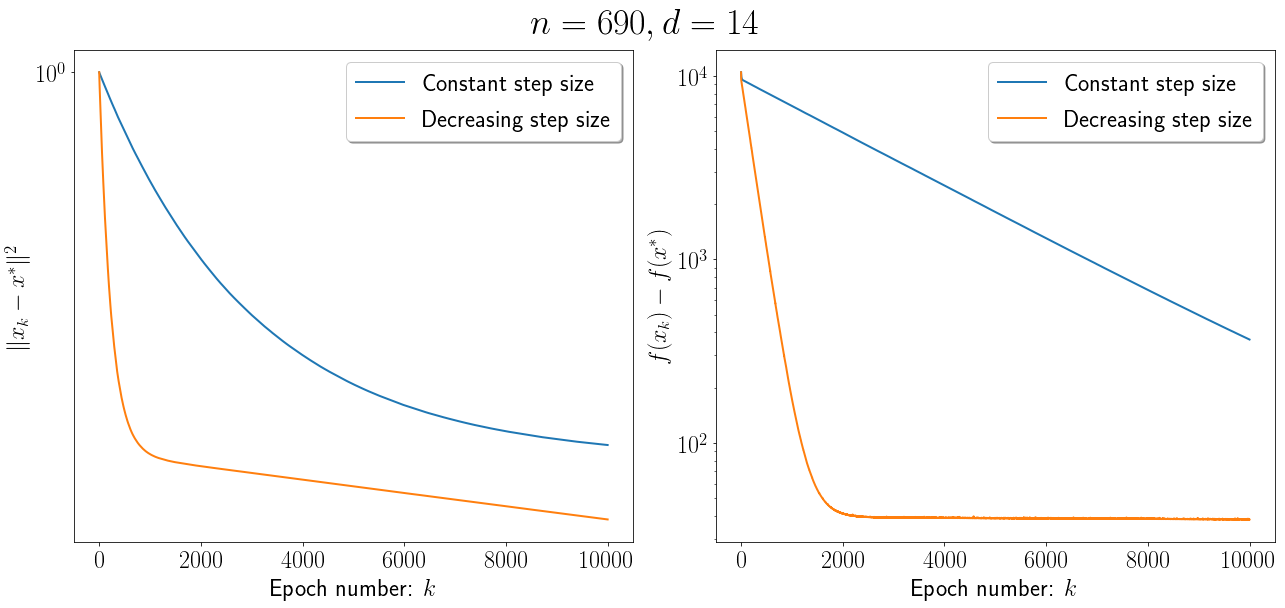

In [167]:
fig = plt.figure(figsize=(18, 8))
st = fig.suptitle(r"$n = {}, d = {}$".format(n, d), fontsize=36)

plt.subplot(1, 2, 1)

plt.semilogy(x_err / la.norm(x_star - x_0)**2, label='Constant step size')
plt.semilogy(x_err_adapt / la.norm(x_star - x_0)**2, label='Decreasing step size')
# plt.axvline(k_switch, color='red', label="Regime switch")
plt.xlabel("Epoch number: $k$")
plt.ylabel(r"$\|x_k - x^*\|^2$")
plt.legend(loc='best', shadow=True)#, fontsize='x-large')

plt.subplot(1, 2, 2)

plt.semilogy(f_vals - f(A, b, x_star) / f(A, b, x_0) - f(A, b, x_star), label='Constant step size')
plt.semilogy(f_vals_adapt - f(A, b, x_star) / f(A, b, x_0) - f(A, b, x_star), label='Decreasing step size')
# plt.axvline(k_switch, color='red', label="Regime switch")
plt.xlabel("Epoch number: $k$")
plt.ylabel(r"$f(x_k) - f(x^*)$")
plt.legend(loc='best', shadow=True)#, fontsize='x-large')

st.set_y(1.05)
fig.subplots_adjust(top=0.95)
plt.tight_layout()
plt.savefig('Sum-of-Non-Convex_Objectives_{}-{}.pdf'.format(n, d), bbox_inches='tight')
plt.show()

### 2 type of $D_i$ generation

In [212]:
k = 1

In [213]:
# Decomposition

D = [np.eye(d) * k / (n - 1) for i in range(n)]

for j in range(d):
    ind = np.random.choice(n)
    D[ind][j, j] = - k

In [214]:
mu = min(la.eigvals(A))
print("mu =", mu)

M = calculate_M(a, D)
h = calculate_h(a, b, D, x_star)
sigma_2, L_curly = calculate_sigma_and_L_curly(M, h)

print("sigma_2 = {} \nL_curly = {}".format(sigma_2, L_curly))

mu = 0.11428616525426238
sigma_2 = 51675699.092747554 
L_curly = 10000403361.251455


In [215]:
# Far from solution
x_0 = np.random.normal(size=len(x_star))

# Closer to solution
# x_0 = x_star + np.random.normal(size=len(x_star))

epsilon = 1e-3

step_size = select_step_size(L_curly, mu, sigma_2, epsilon)
print("Step size:", step_size)

print("Expected minimum number of steps:", 
      max(2 * L_curly / mu, 4 * sigma_2 / (epsilon * mu**2)) * np.log(2 * la.norm(x_star - x_0)**2 / epsilon))

Step size: 5.529009150371704e-13
Expected minimum number of steps: 168022557553167.03


In [216]:
1 / (2 * L_curly)

4.999798327508959e-11

In [82]:
max_epoch = 1000

In [83]:
%%time
x_opt, f_vals, x_err = sgd(A, b, D, x_0, x_star, step_size, batch_size=1, 
                           epsilon=epsilon, max_epoch=max_epoch)

Number of epochs: 10000
Error: 83422.29485135339

CPU times: user 28.5 s, sys: 187 ms, total: 28.7 s
Wall time: 30 s


In [84]:
%%time
x_opt_adapt, f_vals_adapt, x_err_adapt = sgd_adaptive(A, b, D, x_0, x_star, L_curly, mu, batch_size=1, 
                                                      epsilon=epsilon, max_epoch=max_epoch)

Number of epochs: 10000
Error: 905.2526547570698

CPU times: user 28.6 s, sys: 216 ms, total: 28.8 s
Wall time: 29.5 s


In [85]:
# Switching regime from constant to decreasing step size
k_switch = int(4 * np.ceil(L_curly / mu)) / n
k_switch

72.64

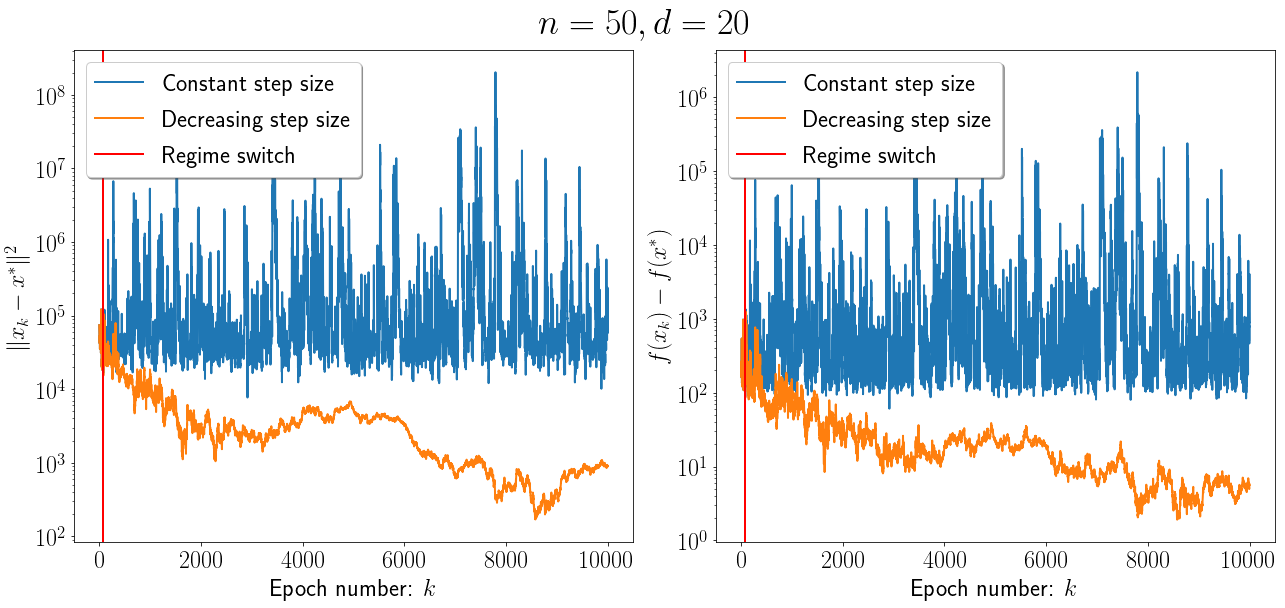

In [86]:
fig = plt.figure(figsize=(18, 8))
st = fig.suptitle(r"$n = {}, d = {}$".format(n, d), fontsize=36)

plt.subplot(1, 2, 1)

plt.semilogy(x_err, label='Constant step size')
plt.semilogy(x_err_adapt, label='Decreasing step size')
plt.axvline(k_switch, color='red', label="Regime switch")
plt.xlabel("Epoch number: $k$")
plt.ylabel(r"$\|x_k - x^*\|^2$")
plt.legend(loc='best', shadow=True)#, fontsize='x-large')

plt.subplot(1, 2, 2)

plt.semilogy(f_vals - f(A, b, x_star), label='Constant step size')
plt.semilogy(f_vals_adapt - f(A, b, x_star), label='Decreasing step size')
plt.axvline(k_switch, color='red', label="Regime switch")
plt.xlabel("Epoch number: $k$")
plt.ylabel(r"$f(x_k) - f(x^*)$")
plt.legend(loc='best', shadow=True)#, fontsize='x-large')

st.set_y(1.05)
fig.subplots_adjust(top=0.95)
plt.tight_layout()
# plt.savefig('synthetic_{}-{}.pdf'.format(n, d), bbox_inches='tight')
plt.savefig('3_Sum-of-Non-Convex_Objectives_{}-{}.pdf'.format(n, d), bbox_inches='tight')
plt.show()